In [24]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [25]:
#function to do color based segmentation
def combined (img):
    #b, g, r = cv2.split(img)
    b = img[:, :, 0]
    g = img[:, :, 1]
    r = img[:, :, 2]
    #r_max = g_max = b_max = 255
    r_max = np.amax(r)
    g_max = np.amax(g)
    b_max = np.amax(b)
    #print (r)
    #cv2.imshow("red chaneel",b)

    red_norm = r/r_max
    green_norm = g/g_max
    blue_norm = b/b_max

   # print(red_norm.shape)

    norm = red_norm + blue_norm + green_norm


    small_num = 0.0001
    r = red_norm/(norm+small_num)
    g = green_norm/(norm+small_num)
    b = blue_norm/(norm+small_num)

    #print('normalized r g b values: %d %d %d' %(r, g, b))

    ExG = 2*g - r - b #excess green

    return ExG

In [26]:
def draw_bb(img, pts):
    #input: array of 4 coordinates
    #output: boundary box
    min_pt = np.min(pts,axis = 0)
    max_pt = np.max(pts,axis = 0)

    cv2.rectangle(img, (int(min_pt[0]),int(min_pt[1])), (int(max_pt[0]),int(max_pt[1])), (255,0,0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [27]:
def draw_points(img, pts,radius = 10):
    #input: array of 4 coordinates
    #output: red dots on coordinate poins
    for (x,y) in pts:
        print(x,y)
        img = cv2.circle(img, (x,y), radius = radius, color=(0, 0, 255), thickness=-1)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [28]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

In [29]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

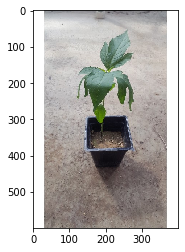

Height: 600 width: 400


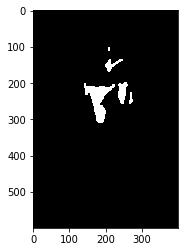

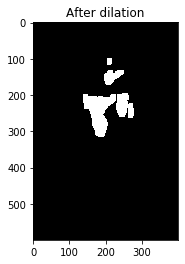

In [30]:
#Load original image, in real case it will video frame
img = cv2.imread(r'C:\Users\khan1\Desktop\Projective_transform\ragweed_front.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


height = img.shape[0]
width = img.shape[1]
print("Height:",height,"width:",width)


### Crop image for Veera video ####
# crop_img = img[int(height / 5):int(height / 2), int(width / 3):int(400+(width / 3))]
# plt.imshow(crop_img)
# plt.show()
# img = crop_img

max_value = np.max(combined(img))
min_value = np.min(combined(img))

###mapped combined image value (which is mostly negative) to 0-255
new_min = 0
new_max = 255
old_range = max_value - min_value
new_range = new_max - new_min
lin_map = (((combined(img).astype(np.float64) - min_value) * new_range) / old_range) + new_min
image_map = lin_map.astype(np.uint8)

###OTSU threshold
thresh_val,thresh_img = cv2.threshold(image_map,0,255,cv2.THRESH_OTSU)


###Morphology Opening-Closing to delete small weed segments
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
#print(closing.shape)
plt.imshow(closing, cmap='gray')
plt.show()

# convert the image to grayscale, blur it, and find edges
# in the image
dilation = cv2.dilate(closing,kernel,iterations = 2)
plt.imshow(dilation, cmap='gray')
plt.title("After dilation")
plt.show()


50.0 0.0
350.0 50.0
50.0 400.0
280.0 450.0


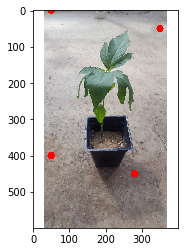

In [31]:
### boundary box coordinates ###
# ideally they will be collected from CNN detetctor
# OR predifed set of points based on camera position
# OR from binary segment image. Find Max and Min white pixel and add ~25 pixels both x,y to get corner points
pts = np.float32([[50,0],[350,50],[50,400],[280,450]])

#draw_bb(img, pts)
draw_points(img,pts)


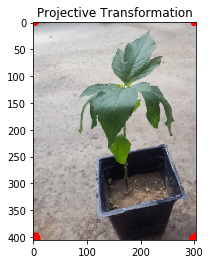

In [32]:
warped = four_point_transform(img, pts)

plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("Projective Transformation")
plt.show()

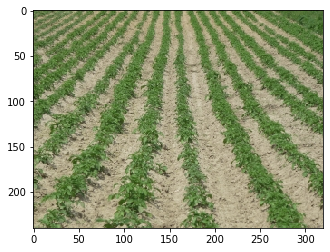

Height: 240 width: 320
105.0 50.0
225.0 50.0
40.0 150.0
300.0 150.0


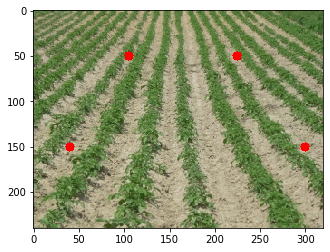

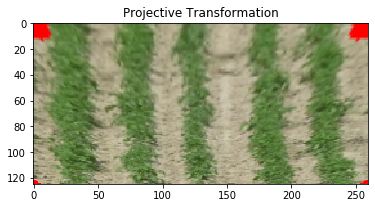

In [33]:
#Load original image, in real case it will video frame
img = cv2.imread(r'C:\Users\khan1\Desktop\Projective_transform\crop_row.JPG')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


height = img.shape[0]
width = img.shape[1]
print("Height:",height,"width:",width)


pts = np.float32([[105,50],[225,50],[40,150],[300,150]])

#draw_bb(img, pts)
draw_points(img,pts,radius = 5)

warped = four_point_transform(img, pts)

plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("Projective Transformation")
plt.show()
